In [1]:
from astropy.table import Table, QTable, join, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants

import numpy as np

import os

import matplotlib.pyplot as plt

In [2]:
c = constants.c.to('km/s')

h = 1
H0 = 100*h

# Read in list of observed PV targets

Generate an updated version of this by running

`bash td_from_program PV > PV_MMDDYYYY.txt`

from the `/global/cscratch1/sd/kadglass` directory.

Last updated: 5/4/2021 (19,697 observations)

In [2]:
PV_filename = 'PV_05042021.txt'

PV_observed = Table.read(PV_filename, 
                         format='ascii.no_header', 
                         delimiter='|', 
                         names=['PROGRAM', 'RA', 'DEC', 'TARGETID', 'TILEID', 'DATE', 'PETAL'])

In [40]:
PV_observed[:10]

PROGRAM,RA,DEC,TARGETID,TILEID,DATE,PETAL
str14,float64,float64,int64,int64,int64,int64
PV_BRIGHT_HIGH,149.171684545314,2.16060616970239,1070167824007172,13,20210407,3
PV_BRIGHT_HIGH,149.658076810033,0.868788172013763,1070131593609233,14,20210408,1
PV_BRIGHT_HIGH,150.356606634878,3.59611185445412,1070198031384587,14,20210408,5
PV_BRIGHT_HIGH,150.267396959543,3.33093628066686,1070191999975425,14,20210408,5
PV_BRIGHT_HIGH,151.099800148199,2.56094576885652,1070173897359360,14,20210408,7
PV_BRIGHT_HIGH,151.403281837345,1.84924206413151,1070155782160385,14,20210408,8
PV_BRIGHT_HIGH,151.006785108655,1.62447667017721,1070149738168328,14,20210408,9
PV_BRIGHT_HIGH,151.145673966004,1.52285422698331,1070149738168325,14,20210408,9
PV_BRIGHT_HIGH,150.823041569144,1.50048971567638,1070149733974017,14,20210408,9


# Identify which of these targets are SGA galaxies

Only because I care about the Tully-Fisher relation and not the Fundamental Plane.  All Tully-Fisher objects are also SGA objects.

### Read in SGA catalog

In [3]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/masking/SGA-ellipse-v3.0.kd.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

In [16]:
SGA.colnames

['SGA_ID',
 'GALAXY',
 'PGC',
 'SGA_RA',
 'SGA_DEC',
 'MORPHTYPE',
 'PA_LEDA',
 'D25_LEDA',
 'BA_LEDA',
 'Z_LEDA',
 'SB_D25_LEDA',
 'MAG_LEDA',
 'BYHAND',
 'REF',
 'IN_FOOTPRINT',
 'IN_FOOTPRINT_GRZ',
 'GROUP_ID',
 'GROUP_NAME',
 'GROUP_MULT',
 'GROUP_PRIMARY',
 'GROUP_RA',
 'GROUP_DEC',
 'GROUP_DIAMETER',
 'BRICKNAME',
 'DIAM',
 'DIAM_REF',
 'PA',
 'BA',
 'ELLIPSEBIT',
 'DROPBIT',
 'RELEASE',
 'BRICKID',
 'OBJID',
 'BRICK_PRIMARY',
 'MASKBITS',
 'ITERATIVE',
 'TYPE',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'BX',
 'BY',
 'DCHISQ',
 'EBV',
 'MJD_MIN',
 'MJD_MAX',
 'REF_CAT',
 'REF_ID',
 'PMRA',
 'PMDEC',
 'PARALLAX',
 'PMRA_IVAR',
 'PMDEC_IVAR',
 'PARALLAX_IVAR',
 'REF_EPOCH',
 'GAIA_POINTSOURCE',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR',
 'GAIA_PHOT_G_N_OBS',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR',
 'GAIA_PHOT_BP_N_OBS',
 'GAIA_PHOT_RP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR',
 'GAIA_PHOT_RP_N_OBS',
 'GAIA_PHOT_VARIABLE_FLAG',
 'GAIA_

### Match the observed targets to the SGA catalog by sky position

In [4]:
SGA_coords = SkyCoord(ra=SGA['SGA_RA']*u.degree, dec=SGA['SGA_DEC']*u.degree)
'''
PV_coords = SkyCoord(ra=PV_observed['RA']*u.degree, dec=PV_observed['DEC']*u.degree)

idx, d2d, d3d = PV_coords.match_to_catalog_sky(SGA_coords)

PV_observed['IDX_SGA'] = idx
PV_observed['SKY_DIST_SGA'] = d2d
''';

### Eliminate those objects which are not actually SGA galaxies

Implement a distance maximum

In [54]:
# SGA targets were placed along the semi-major axis, out to a distance of D(26)
sep_constraint = d2d <= 0.5*SGA['DIAM'][PV_observed['IDX_SGA']]*u.arcmin

PV_SGA_observed = PV_observed[sep_constraint]

In [47]:
# Save just the target info to disk (for upoloading to the Legacy Survey viewer)
PV_SGA_observed[['RA', 'DEC', 'TARGETID']].write('PV_targets.fits', format='fits')

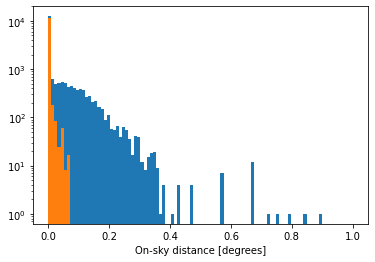

In [57]:
plt.figure()

plt.hist(PV_observed['SKY_DIST_SGA'], bins=np.linspace(0, 1, 100))
plt.hist(PV_SGA_observed['SKY_DIST_SGA'], bins=np.linspace(0,1,100))

plt.yscale('log')

plt.xlabel('On-sky distance [degrees]');

# Locate and extract the Redrock redshifts for each of the observed TF spectra

### Add columns to table

In [58]:
redux = 'daily'

ztable = None

for i, pv_target in enumerate(PV_SGA_observed):
    zbdir = '{}/{}/tiles/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, pv_target['TILEID'], pv_target['DATE'])
    zbfile = '{}/zbest-{}-{}-{}.fits'.format(zbdir, pv_target['PETAL'], pv_target['TILEID'], pv_target['DATE'])
    
    if os.path.exists(zbfile):
        hdus = fits.open(zbfile)
        zbest = hdus['ZBEST'].data
        select = zbest['TARGETID'] == pv_target['TARGETID']
        
        if ztable is None:
            ztable = join(pv_target, zbest[select], keys='TARGETID')
        else:
            ztable = vstack([ztable, join(pv_target, zbest[select], keys='TARGETID')])
            
    if (i+1)%100 == 0:
        print('{} out of {}'.format(i+1, len(PV_SGA_observed)))

100 out of 12125
200 out of 12125
300 out of 12125
400 out of 12125
500 out of 12125
600 out of 12125
700 out of 12125
800 out of 12125
900 out of 12125
1000 out of 12125
1100 out of 12125
1200 out of 12125
1300 out of 12125
1400 out of 12125
1500 out of 12125
1600 out of 12125
1700 out of 12125
1800 out of 12125
1900 out of 12125
2000 out of 12125
2100 out of 12125
2200 out of 12125
2300 out of 12125
2400 out of 12125
2500 out of 12125
2600 out of 12125
2700 out of 12125
2800 out of 12125
2900 out of 12125
3000 out of 12125
3100 out of 12125
3200 out of 12125
3300 out of 12125
3400 out of 12125
3500 out of 12125
3600 out of 12125
3700 out of 12125
3800 out of 12125
3900 out of 12125
4000 out of 12125
4100 out of 12125
4200 out of 12125
4300 out of 12125
4400 out of 12125
4500 out of 12125
4600 out of 12125
4700 out of 12125
4800 out of 12125
4900 out of 12125
5000 out of 12125
5100 out of 12125
5200 out of 12125
5300 out of 12125
5400 out of 12125
5500 out of 12125
5600 out of 12125
5

In [60]:
# Save file to disk
PV_filename_parts = PV_filename.split('_')
ztable_filename = PV_filename_parts[0] + '_SGA_z_' + PV_filename_parts[1]

ztable.write(ztable_filename[:-4]+'.fits', format='fits', overwrite=True)

In [5]:
# Read in saved file from disk
ztable = QTable.read('../PV_SGA_z_05042021.fits')

# Calculate the rotational velocity for each axis target

First, we need to find the galaxy's central redshift (if it exists).

In [6]:
LSS_directory = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/v0/'
BGS_filename = LSS_directory + 'ALLAlltiles_bright_full.dat.fits'

hdu = fits.open(BGS_filename)
BGS = hdu[1].data
hdu.close()

BGS.names

['TARGETID',
 'FIBER',
 'LOCATION_AVAIL',
 'RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLU

#### Build a SkyCoord object for the BGS catalog so that we can match the SGA galaxies to it.

In [7]:
BGS_coords = SkyCoord(ra=BGS['RA']*u.degree, dec=BGS['DEC']*u.degree)

SGA_idx, SGA_d2d, SGA_d3d = SGA_coords.match_to_catalog_sky(BGS_coords)

SGA['IDX_BGS'] = SGA_idx
SGA['SKY_DIST_BGS'] = SGA_d2d

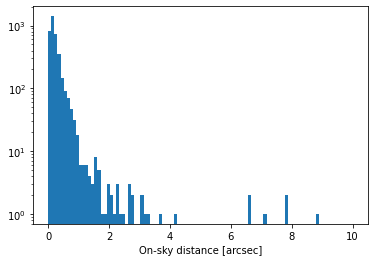

In [39]:
plt.figure()
plt.hist(SGA['SKY_DIST_BGS'].to(u.arcsec).data, bins=np.linspace(0,10,100))
plt.xlabel('On-sky distance [arcsec]')
plt.yscale('log')

Matches correspond to objects with sky separations < 5".

In [8]:
SGA['Z'] = np.nan*np.ones(len(SGA))
SGA['ZERR'] = np.nan*np.ones(len(SGA))

SGA_matches = SGA['SKY_DIST_BGS'].to(u.arcsec) <= 5*u.arcsec

SGA['Z'][SGA_matches] = BGS['Z'][SGA['IDX_BGS'][SGA_matches]]
SGA['ZERR'][SGA_matches] = BGS['ZERR'][SGA['IDX_BGS'][SGA_matches]]

In [9]:
def rot_vel(targets, center):
    '''
    Calculate the rotational velocity of a set of observations based on 
    the difference in redshifts between the observations and the center 
    of the galaxy.
    
    
    PARAMETERS
    ==========
    
    targets : astropy table
        list of observations for a given object.  Field names should include
        RA, DEC, Z
        
    center : astropy table row
        Defining information for the galaxy's center.  Field names should 
        include DIAM (the diameter of the galaxy at 26-mag)
        
    
    RETURNS
    =======
    
    targets : astropy table
        Adds a column with the velocities of the observations relative to 
        the galaxy's center.  Units are km/s.  Also adds a column of the 
        distance to the observation (in units of kpc); the redshift of the 
        galaxy's center is used as the distance proxy.
    '''
    
    ############################################################################
    # Figure out which redshift(s) belong to the galaxy's center - should be the 
    # target closest to the center
    #---------------------------------------------------------------------------
    #center_idx = np.argmin(targets['SKY_DIST_SGA'])
    ############################################################################
    
    
    ############################################################################
    # Calculate the relative velocities
    #---------------------------------------------------------------------------
    targets['V_ROT'] = c*(targets['Z'] - center['Z'])
    
    targets['V_ROT_ERR'] = c*np.sqrt(targets['ZERR']**2 + center['ZERR']**2)
    ############################################################################
    
    
    ############################################################################
    # Calculate the distance to the observations in units of the diameter
    #---------------------------------------------------------------------------
    targets['RADIUS'] = targets['SKY_DIST_SGA']/(0.5*center['DIAM']*u.arcmin).to(u.degree)
    ############################################################################
    
    return targets

In [10]:
PV_SGA_ztable = None

for i in np.unique(ztable['IDX_SGA']):
    idx_bool = ztable['IDX_SGA'] == i
    
    PV_galaxy = ztable[idx_bool]
    
    if len(PV_galaxy) > 1 and len(np.unique(PV_galaxy['TARGETID'])) > 1 and np.isfinite(SGA['Z'][i]):
        #print(SGA['GALAXY'][i])
        #ztable[['RA', 'DEC', 'TARGETID', 'Z', 'SPECTYPE']][idx_bool].pprint()
        
        PV_galaxy = rot_vel(PV_galaxy, SGA[i])
        
        if PV_SGA_ztable is None:
            PV_SGA_ztable = PV_galaxy
        else:
            PV_SGA_ztable = vstack([PV_SGA_ztable, PV_galaxy])
        '''
        plt.figure()
        plt.scatter(SGA['SGA_RA'][i], SGA['SGA_DEC'][i], s=50, marker='x')
        plt.scatter(ztable['RA'][idx_bool], ztable['DEC'][idx_bool], s=50)
        plt.xlabel(r'$\alpha$ [degrees]')
        plt.ylabel(r'$\delta$ [degrees]')
        plt.tight_layout()
        
        break
        '''

In [11]:
# Save this full data table to disk
PV_SGA_ztable.write('../PV_SGA_vel_05042021.fits', format='fits')

In [ ]:
# Read in latest data table
PV_SGA_ztable = QTable.read('../PV_SGA_vel_05042021.fits', format='fits')

## For any of the large SGA galaxies, plot the rotation curve

Include the MaNGA rotation curve, if it exists.

In [97]:
for i in np.unique(PV_SGA_ztable['IDX_SGA']):
    idx_bool = PV_SGA_ztable['IDX_SGA'] == i
    
    PV_galaxy = PV_SGA_ztable[idx_bool]
    
    ################################################################################
    # Plot rotation curve
    #-------------------------------------------------------------------------------
    plt.figure()
    plt.title(SGA['GALAXY'][i])
    plt.plot(0, 0, 'mo')
    
    if 'GALAXY' in PV_galaxy['SPECTYPE']:
        plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'GALAXY'], 
                     np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data), 
                     yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data, 
                     fmt='o', c='b', label='Galaxy')
    if 'STAR' in PV_galaxy['SPECTYPE']:
        plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'STAR'], 
                     np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'STAR'].data), 
                     yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'STAR'].data, 
                     fmt='*', c='orange', label='Star')
    if 'QSO' in PV_galaxy['SPECTYPE']:
        plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'QSO'], 
                     np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'QSO'].data), 
                     yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'QSO'].data, 
                     fmt='.', c='g', label='QSO')
    
    for (r,v) in zip(PV_galaxy['RADIUS'].data, np.abs(PV_galaxy['V_ROT'].data)):
        label = '{:.1f}'.format(v)
        
        plt.annotate(label, 
                     (r,v), 
                     textcoords='offset points', 
                     xytext=(10,0), 
                     backgroundcolor='white')
    
    plt.xlabel('Distance from galaxy center [R(26)]')
    plt.ylabel('$V_{rot}$ [km/s]')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('images/PV_curves/'+SGA['GALAXY'][i]+'.png')
    plt.close()
    ################################################################################
    
    #break

#### Only plot those curves with multiple good velocity values

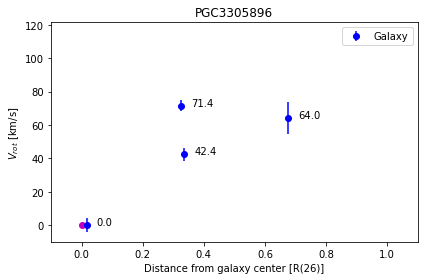

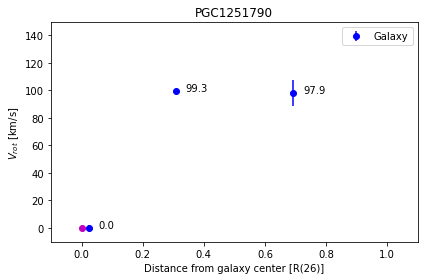

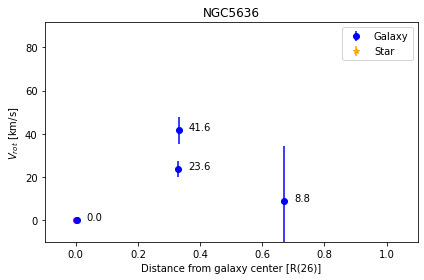

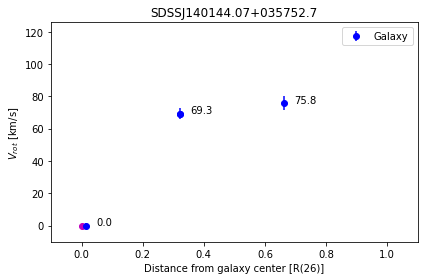

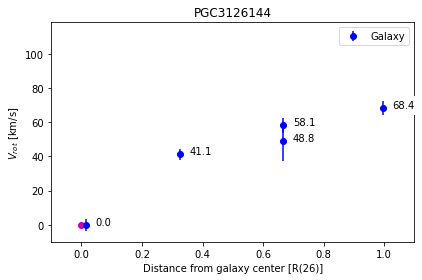

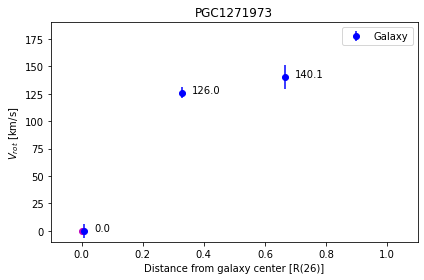

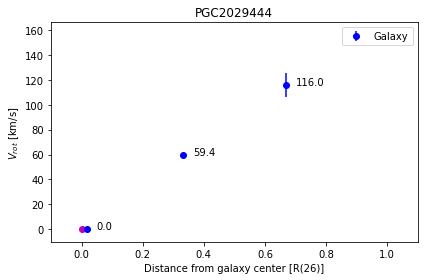

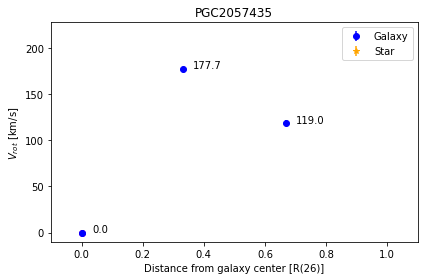

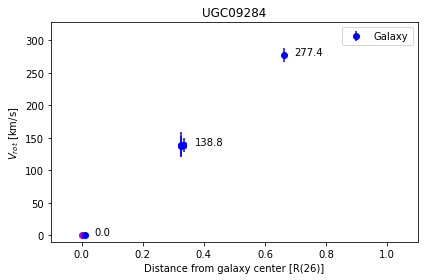

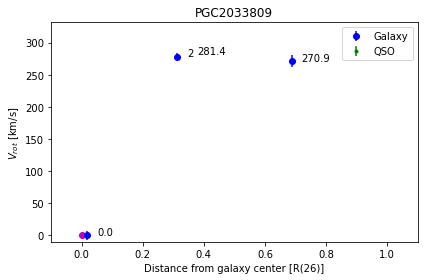

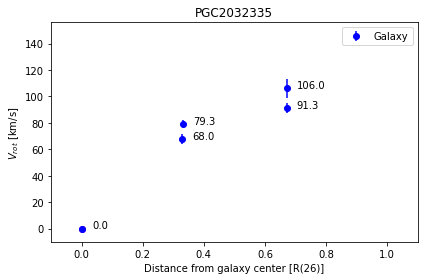

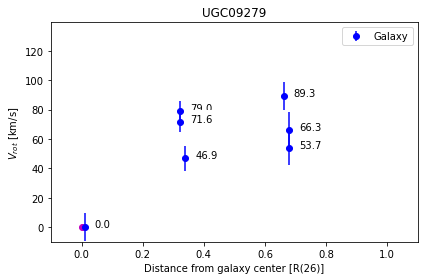

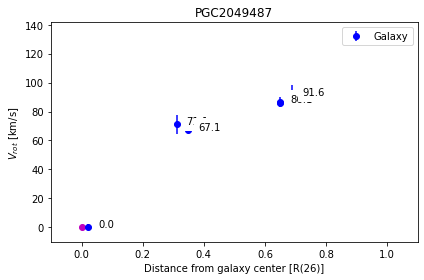

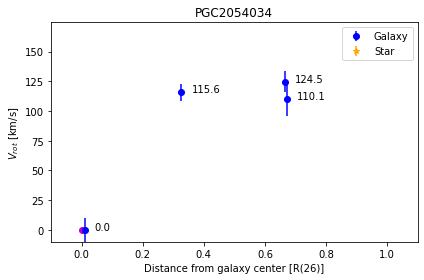

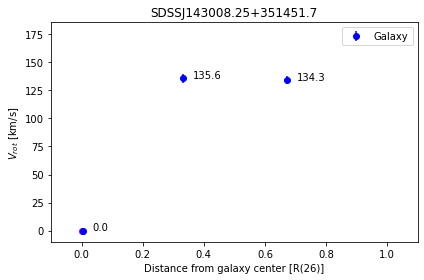

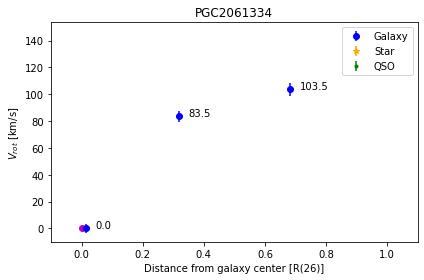

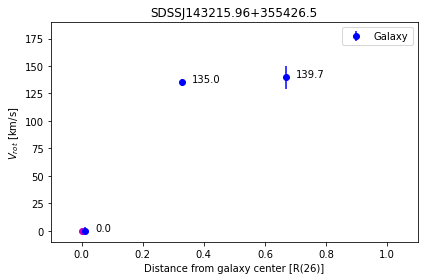

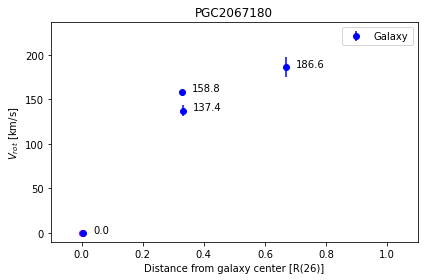

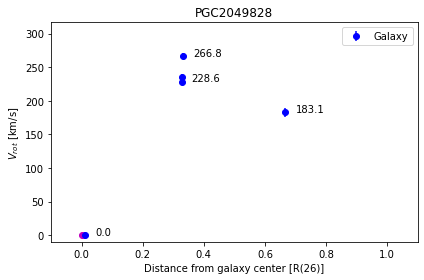

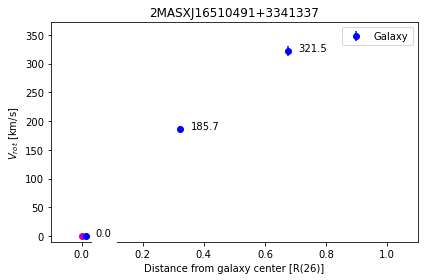

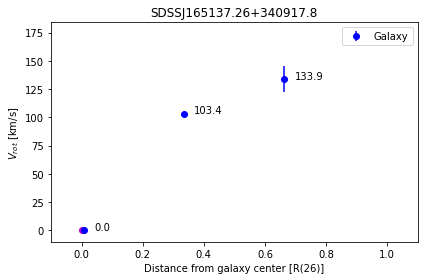

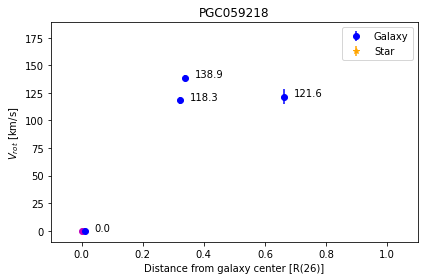

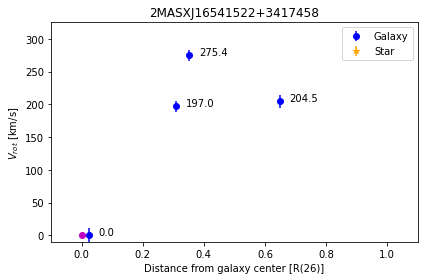

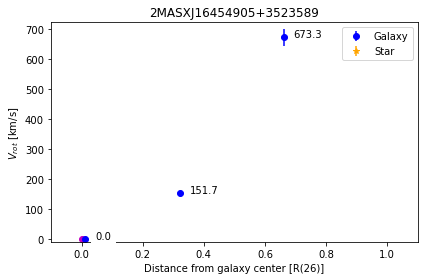

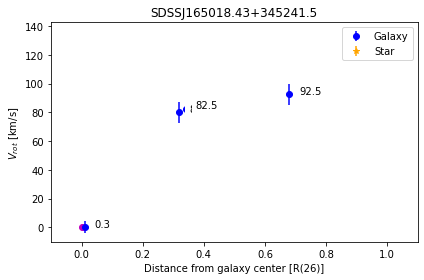

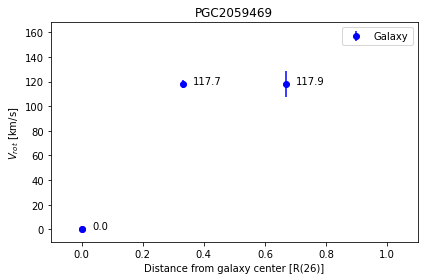

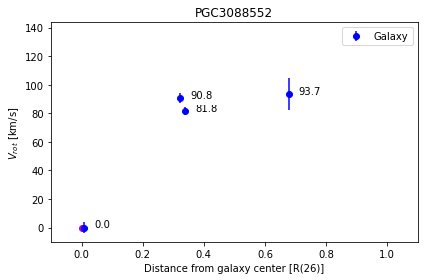

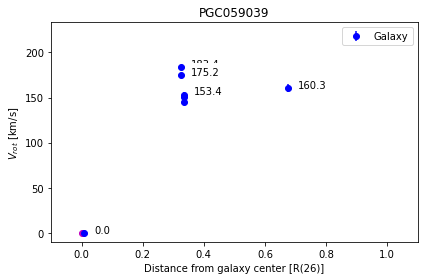

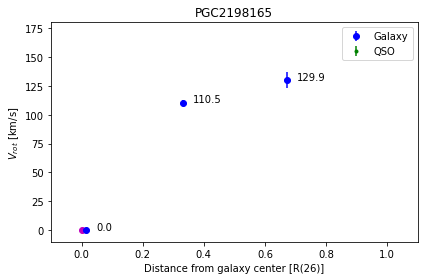

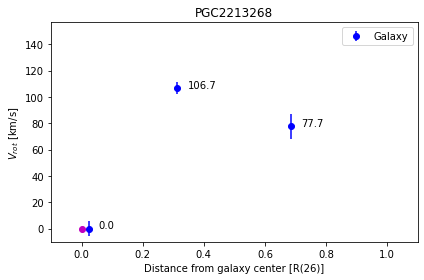

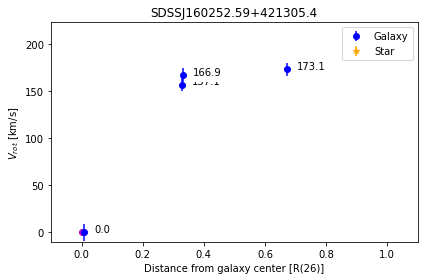

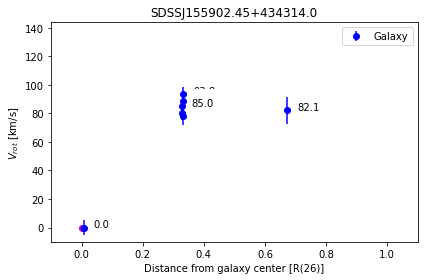

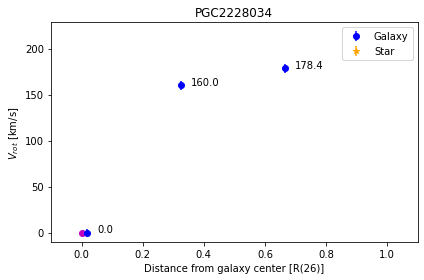

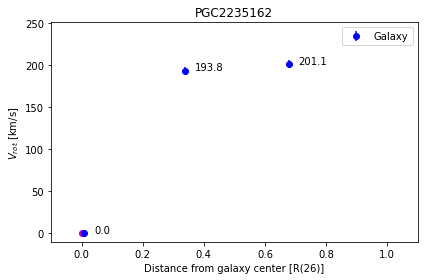

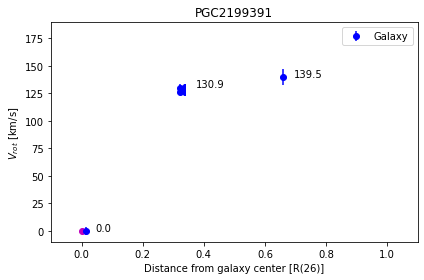

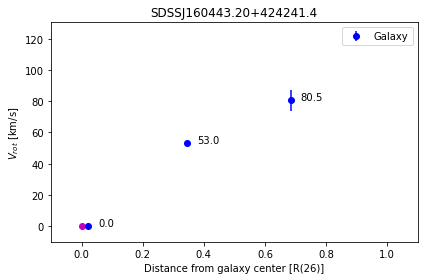

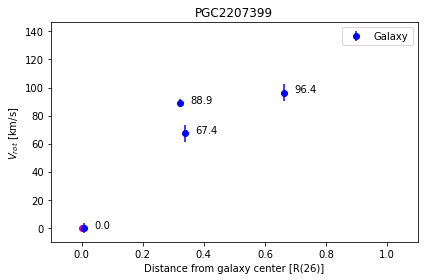

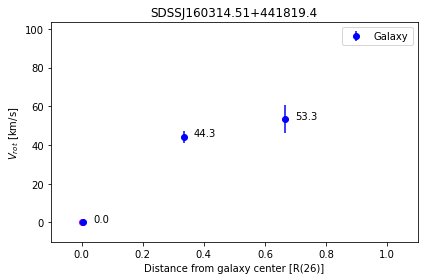

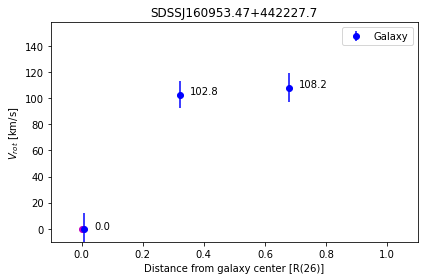

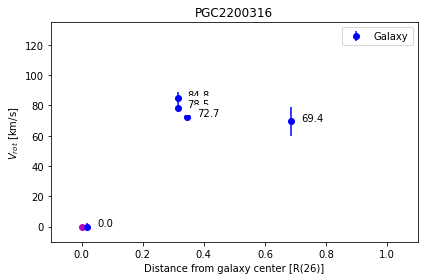

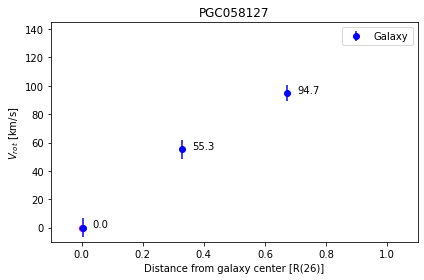

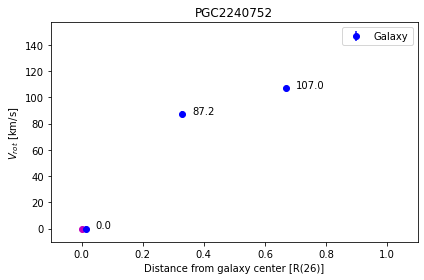

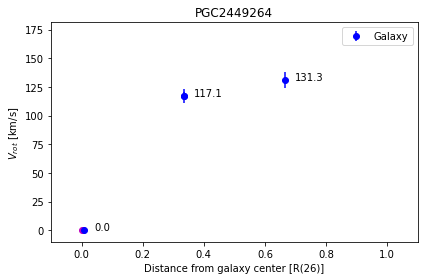

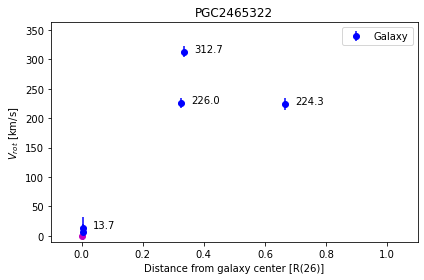

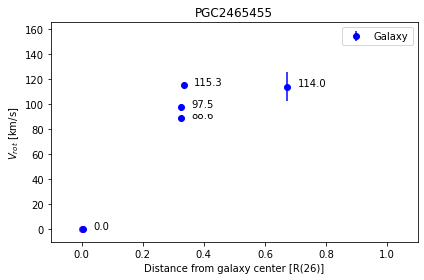

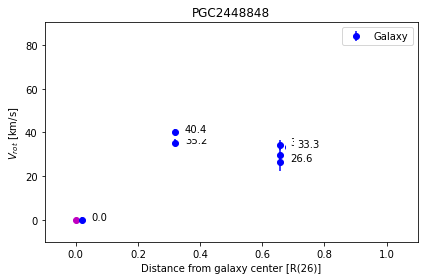

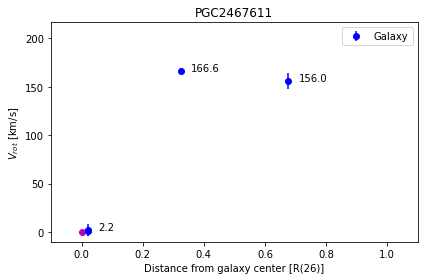

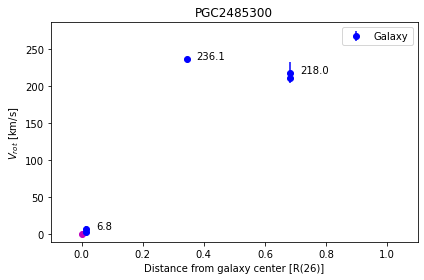

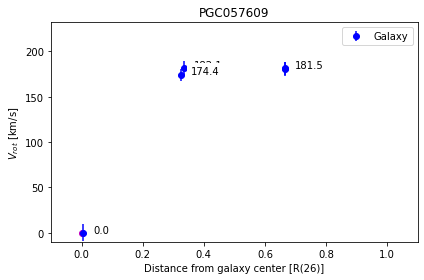

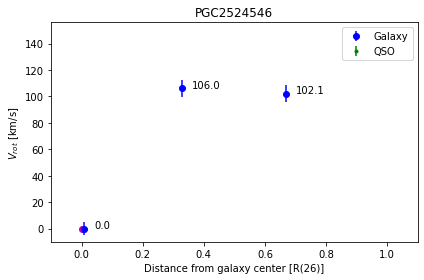

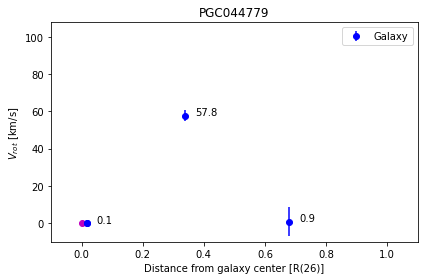

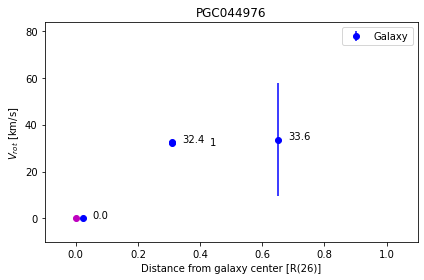

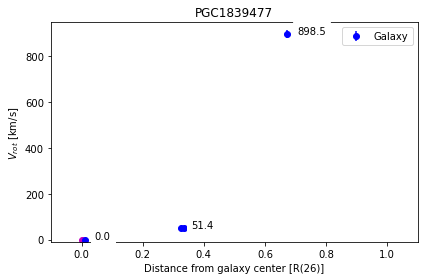

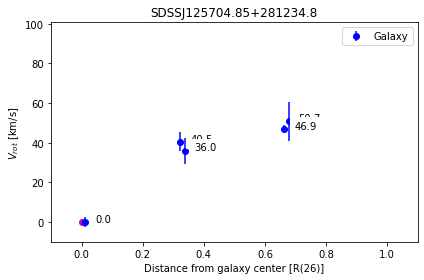

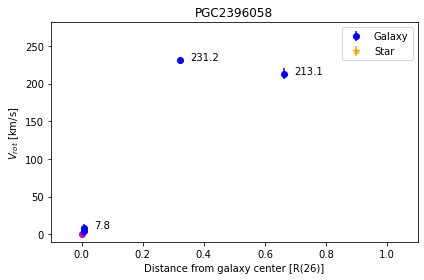

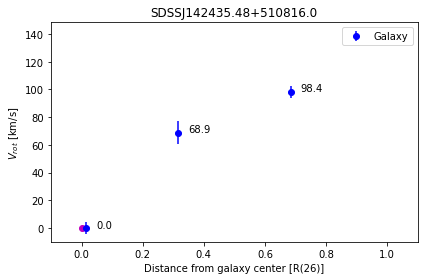

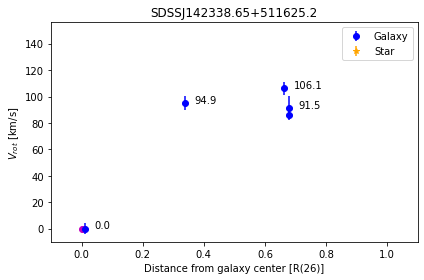

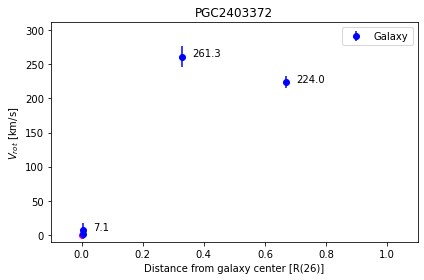

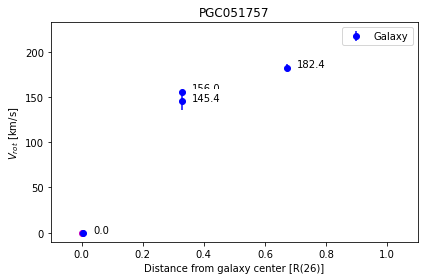

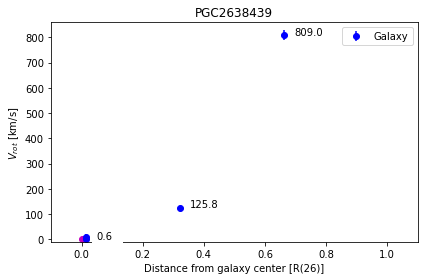

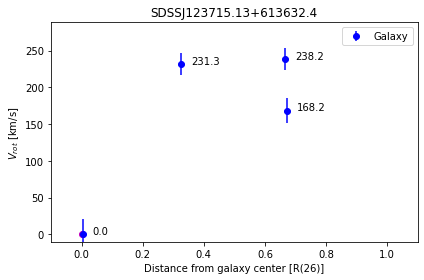

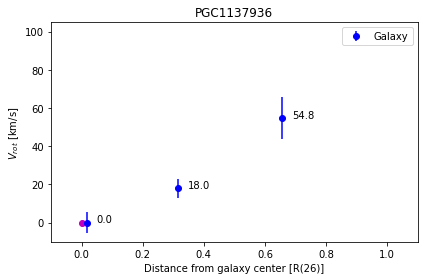

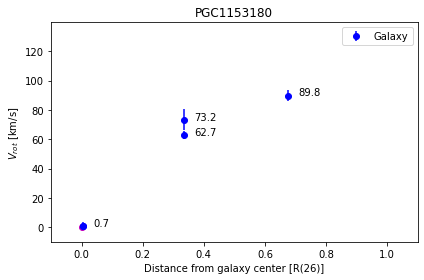

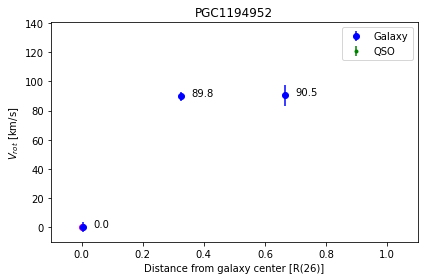

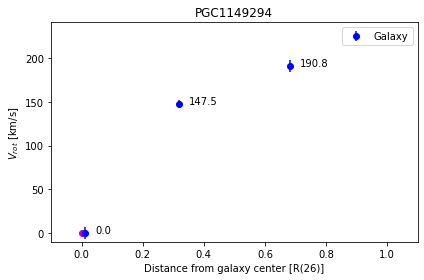

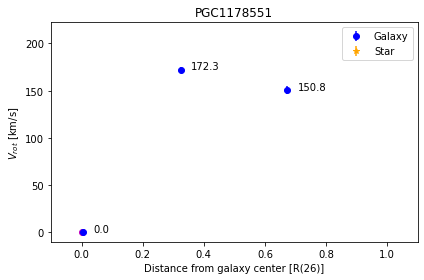

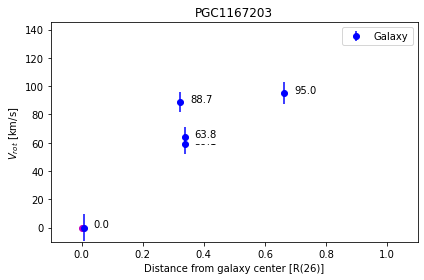

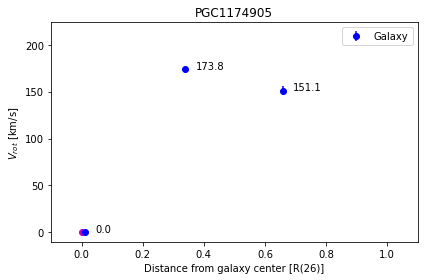

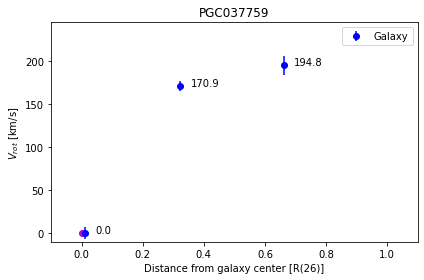

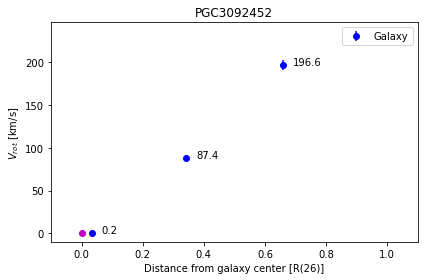

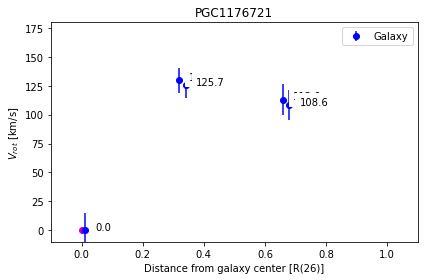

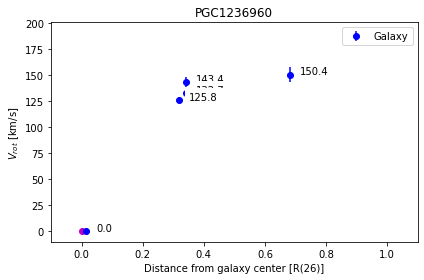

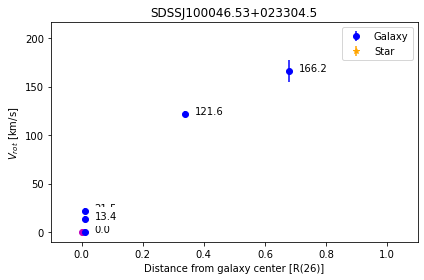

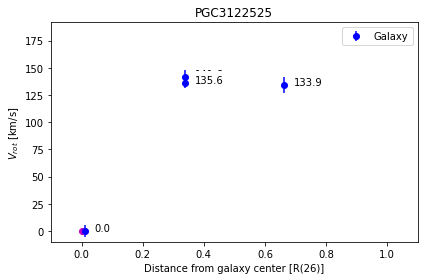

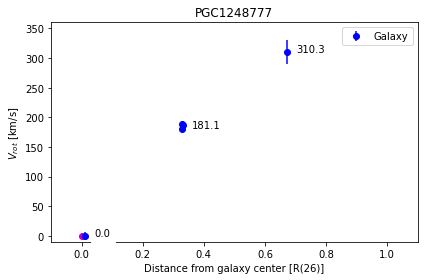

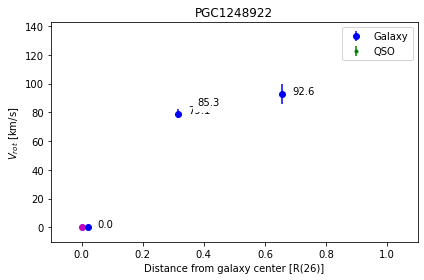

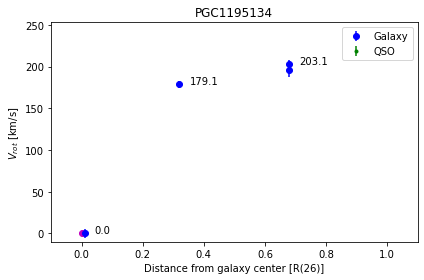

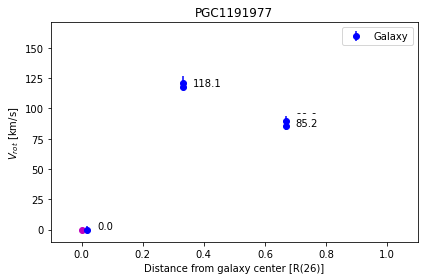

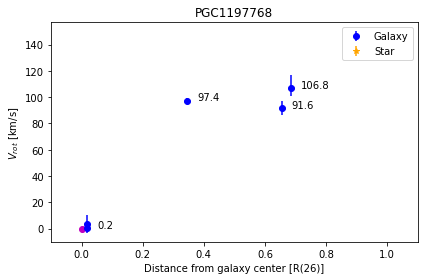

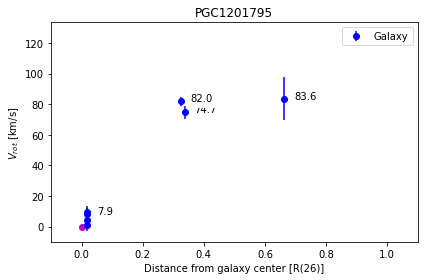

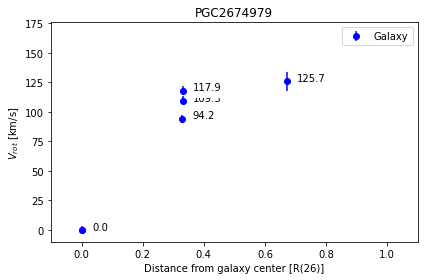

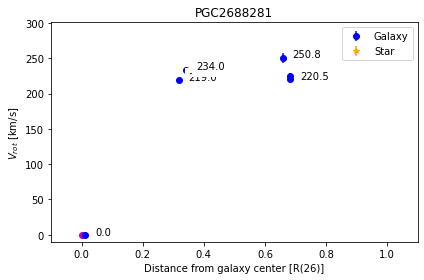

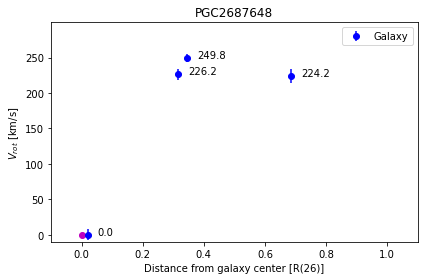

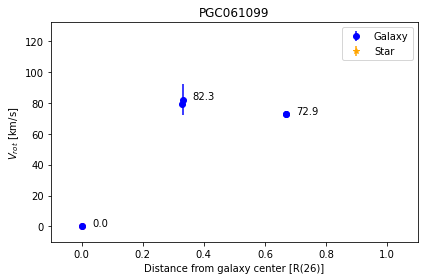

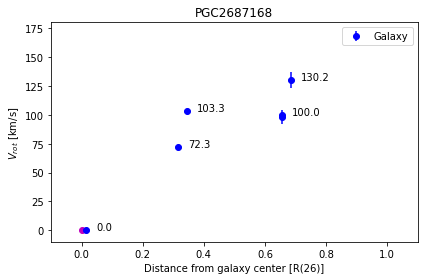

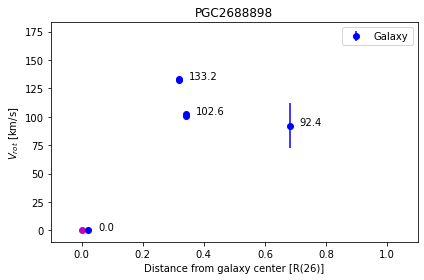

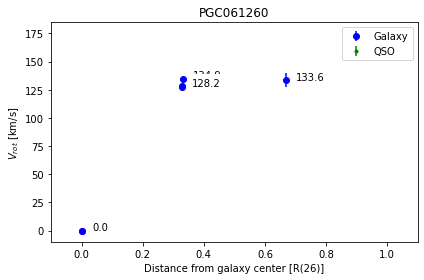

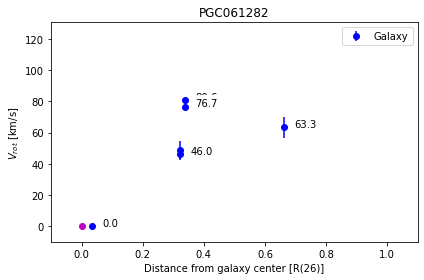

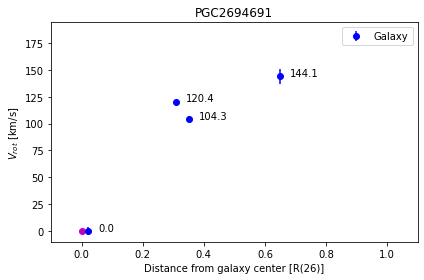

In [47]:
v_diff = []

for i in np.unique(PV_SGA_ztable['IDX_SGA']):
    idx_bool = PV_SGA_ztable['IDX_SGA'] == i
    
    PV_galaxy = PV_SGA_ztable[idx_bool]
    
    ################################################################################
    # Do we have a good observation at at least 2 different radii?
    #-------------------------------------------------------------------------------
    good_bool = np.abs(PV_galaxy['V_ROT']) < 1000*u.km/u.s
    
    num_0p3 = np.sum(np.logical_and(PV_galaxy['RADIUS'][good_bool] > 0.3, 
                                    PV_galaxy['RADIUS'][good_bool] < 0.35))
    
    num_0p6 = np.sum(np.logical_and(PV_galaxy['RADIUS'][good_bool] > 0.6, 
                                    PV_galaxy['RADIUS'][good_bool] < 0.7))

    num_1 = np.sum(PV_galaxy['RADIUS'][good_bool] > 0.95)
    
    check = [num_0p3 > 0, num_0p6 > 0, num_1 > 0]
    
    if sum(check) > 1:
        #print(PV_galaxy['RADIUS', 'V_ROT'])
        ymax = np.max(np.abs(PV_galaxy['V_ROT'][np.abs(PV_galaxy['V_ROT']) < 1000*u.km/u.s]))
        
        ############################################################################
        # Calculate the difference between the velocity measured at 0.6 and 0.3 R26
        #---------------------------------------------------------------------------
        v0p3 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         PV_galaxy['RADIUS'] > 0.3, 
                                                         PV_galaxy['RADIUS'] < 0.35])]
        v0p6 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         PV_galaxy['RADIUS'] > 0.6, 
                                                         PV_galaxy['RADIUS'] < 0.7])]
        
        dv = np.mean(np.abs(v0p6)) - np.mean(np.abs(v0p3))
        v_diff.append(dv.value)
        ############################################################################
        
        
        ############################################################################
        # Plot rotation curve
        #---------------------------------------------------------------------------
        plt.figure()
        plt.title(SGA['GALAXY'][i])
        plt.plot(0, 0, 'mo')

        if 'GALAXY' in PV_galaxy['SPECTYPE']:
            plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'GALAXY'], 
                         np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data), 
                         yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data, 
                         fmt='o', c='b', label='Galaxy')
        if 'STAR' in PV_galaxy['SPECTYPE']:
            plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'STAR'], 
                         np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'STAR'].data), 
                         yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'STAR'].data, 
                         fmt='*', c='orange', label='Star')
        if 'QSO' in PV_galaxy['SPECTYPE']:
            plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'QSO'], 
                         np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'QSO'].data), 
                         yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'QSO'].data, 
                         fmt='.', c='g', label='QSO')

        for (r,v) in zip(PV_galaxy['RADIUS'].data, np.abs(PV_galaxy['V_ROT'].data)):
            if v < 1000:
                label = '{:.1f}'.format(v)

                plt.annotate(label, 
                             (r,v), 
                             textcoords='offset points', 
                             xytext=(10,0), 
                             backgroundcolor='white')
        
        plt.xlim((-0.1, 1.1))
        plt.ylim((-10,ymax.value + 50))
        
        plt.xlabel('Distance from galaxy center [R(26)]')
        plt.ylabel('$V_{rot}$ [km/s]')
        plt.legend()
        plt.tight_layout()

        plt.show()
        plt.close()
        ############################################################################
    ################################################################################
    
    #break

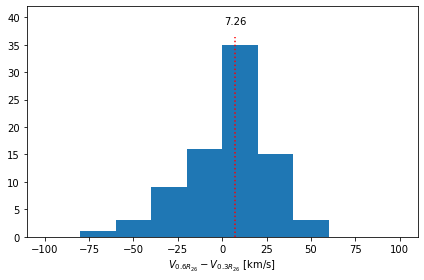

In [66]:
plt.figure()

plt.hist(np.array(v_diff), bins=np.linspace(-100,100,11))
plt.vlines(np.median(v_diff), 0,36.5, colors='r', linestyles=':')

plt.annotate('{:.2f}'.format(np.median(v_diff)), 
             (np.median(v_diff), 37), 
             textcoords='offset points', 
             xytext=(0,10), 
             #backgroundcolor='white', 
             ha='center')

plt.ylim(ymax=42)

plt.xlabel('$V_{0.6R_{26}} - V_{0.3R_{26}}$ [km/s]')

plt.tight_layout()

plt.savefig('../images/SV3_vdiff.png', dpi=300, transparent=True)

# Observation statistics

### What is the distribution of classification of the spectra (galaxy, star, qso) by Redrock?

In [23]:
r0p3 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.3, PV_SGA_ztable['RADIUS'] < 0.35)
r0p6 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.6, PV_SGA_ztable['RADIUS'] < 0.7)
r1 = PV_SGA_ztable['RADIUS'] > 0.95

bright = np.logical_or.reduce([PV_SGA_ztable['PROGRAM'] == 'PV_BRIGHT_HIGH', 
                               PV_SGA_ztable['PROGRAM'] == 'PV_BRIGHT_MID', 
                               PV_SGA_ztable['PROGRAM'] == 'PV_BRIGHT_LOW'])
dark = np.logical_or.reduce([PV_SGA_ztable['PROGRAM'] == 'PV_DARK_HIGH', 
                             PV_SGA_ztable['PROGRAM'] == 'PV_DARK_MID', 
                             PV_SGA_ztable['PROGRAM'] == 'PV_DARK_LOW'])

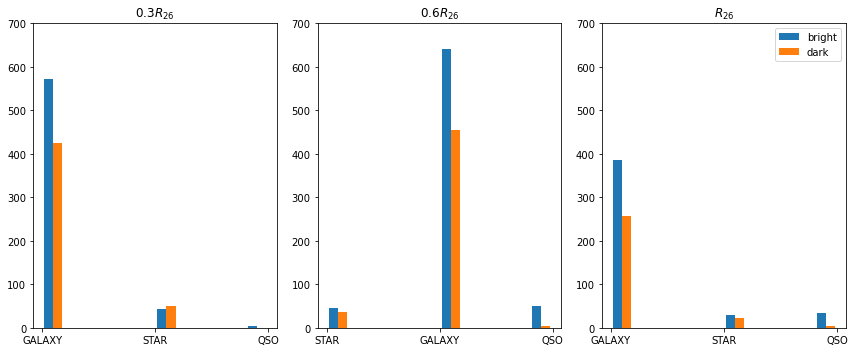

In [30]:
plt.figure(figsize=(12,5))

plt.subplot(131)
plt.hist([PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p3, bright)], 
          PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p3, dark)]], 
         label=['bright', 'dark'])
plt.title('$0.3R_{26}$')
plt.ylim(ymax=700)

plt.subplot(132)
plt.hist([PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p6, bright)], 
          PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p6, dark)]], 
         label=['bright', 'dark'])
plt.title('$0.6R_{26}$')
plt.ylim(ymax=700)

plt.subplot(133)
plt.hist([PV_SGA_ztable['SPECTYPE'][np.logical_and(r1, bright)], 
          PV_SGA_ztable['SPECTYPE'][np.logical_and(r1, dark)]], 
         label=['bright', 'dark'])
plt.title('$R_{26}$')
plt.ylim(ymax=700)
plt.legend()

plt.tight_layout()

### What is the distribution in velocity uncertainties at each radius?

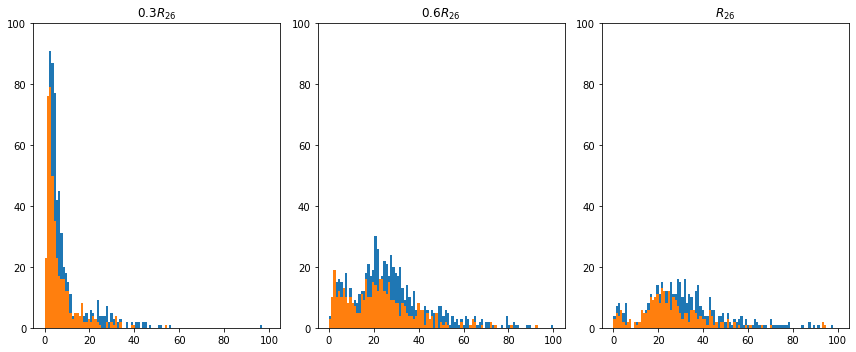

In [32]:
plt.figure(figsize=(12,5))

zerr_bins = np.linspace(0,0.002, 50)
verr_bins = np.linspace(0,100, 100)

plt.subplot(131)
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p3, bright)].data, 
         bins=verr_bins, label='bright')
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p3, dark)].data, 
         bins=verr_bins, label='dark')
plt.title('$0.3R_{26}$')
plt.ylim(ymax=100)

plt.subplot(132)
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p6, bright)].data, 
         bins=verr_bins, label='bright')
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p6, dark)].data, 
         bins=verr_bins, label='dark')
plt.title('$0.6R_{26}$')
plt.ylim(ymax=100)

plt.subplot(133)
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r1, bright)].data, 
         bins=verr_bins, label='bright')
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r1, dark)].data, 
         bins=verr_bins, label='dark')
plt.title('$R_{26}$')
plt.ylim(ymax=100)

plt.tight_layout()

### What is the distribution in velocities at each radius?

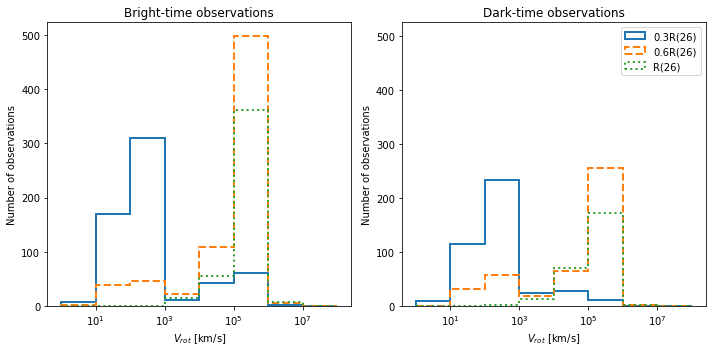

In [40]:
plt.figure(figsize=(10,5))

v_bins = np.logspace(0,8, 9)
lwidth = 2

plt.subplot(121)
plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         label='0.3R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle='--',
         label='0.6R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle=':',
         label='R(26)')

plt.xscale('log')

plt.title('Bright-time observations')
plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('Number of observations')



plt.subplot(122)
plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         label='0.3R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle='--',
         label='0.6R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle=':',
         label='R(26)')

plt.xscale('log')
plt.ylim(ymax=525)

plt.title('Dark-time observations')
plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('Number of observations')

plt.legend()

plt.tight_layout()

plt.savefig('../images/SV3_Vrot_hist.png', dpi=300, transparent=True)

In [38]:
v_max = 1000*u.km/u.s

# 0.3R26
print('0.33 R26')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p3] < v_max)/np.sum(r0p3))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p3] > v_max)/np.sum(r0p3))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)] < v_max)/np.sum(np.logical_and(r0p3, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)] > v_max)/np.sum(np.logical_and(r0p3, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)] < v_max)/np.sum(np.logical_and(r0p3, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)] > v_max)/np.sum(np.logical_and(r0p3, dark)))
print('\n')

# 0.6R26
print('0.66 R26')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p6] < v_max)/np.sum(r0p6))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p6] > v_max)/np.sum(r0p6))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)] < v_max)/np.sum(np.logical_and(r0p6, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)] > v_max)/np.sum(np.logical_and(r0p6, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)] < v_max)/np.sum(np.logical_and(r0p6, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)] > v_max)/np.sum(np.logical_and(r0p6, dark)))
print('\n')

# R26
print('R26')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r1] < v_max)/np.sum(r1))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r1] > v_max)/np.sum(r1))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)] < v_max)/np.sum(np.logical_and(r1, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)] > v_max)/np.sum(np.logical_and(r1, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)] < v_max)/np.sum(np.logical_and(r1, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)] > v_max)/np.sum(np.logical_and(r1, dark)))

0.33 R26
----------------------------------------------------
Fraction of successful redshifts 0.9170464904284412
Fraction of failed redshifts 0.0829535095715588
Fraction of successful redshifts during bright time 0.8792270531400966
Fraction of failed redshifts during bright time 0.12077294685990338
Fraction of successful redshifts during dark time 0.9663865546218487
Fraction of failed redshifts during dark time 0.03361344537815126


0.66 R26
----------------------------------------------------
Fraction of successful redshifts 0.28304947283049475
Fraction of failed redshifts 0.7169505271695052
Fraction of successful redshifts during bright time 0.2130257801899593
Fraction of failed redshifts during bright time 0.7869742198100407
Fraction of successful redshifts during dark time 0.3870967741935484
Fraction of failed redshifts during dark time 0.6129032258064516


R26
----------------------------------------------------
Fraction of successful redshifts 0.12806539509536785
Fraction of fai

### Is there a correlation between inclination angle and a successful redshift?

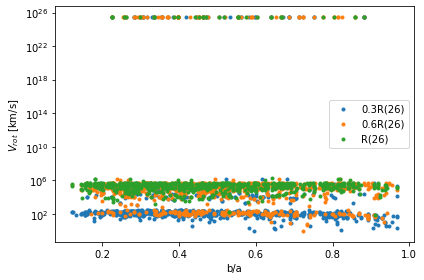

In [74]:
plt.figure()

r0p3 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.3, PV_SGA_ztable['RADIUS'] < 0.35)
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r0p3]], 
             np.abs(PV_SGA_ztable['V_ROT'][r0p3]), '.', label='0.3R(26)')

r0p6 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.6, PV_SGA_ztable['RADIUS'] < 0.7)
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r0p6]], 
             np.abs(PV_SGA_ztable['V_ROT'][r0p6]), '.', label='0.6R(26)')

r1 = PV_SGA_ztable['RADIUS'] > 0.95
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r1]], 
             np.abs(PV_SGA_ztable['V_ROT'][r1]), '.', label='R(26)')

plt.xlabel('b/a')
plt.ylabel('$V_{rot}$ [km/s]')

plt.legend()

plt.tight_layout()